In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import distributions
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import time
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')
import warnings
warnings.simplefilter('ignore')
import pandas as pd
from pandas import Series, DataFrame
from numpy.random import randint, randn, rand
import copy
import os
import pickle

//anaconda/envs/python3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Long Homework 2

## AMPTH 207: Stochastic Methods for Data Analysis, Inference and Optimization
 
### Long Homework 2
 
**Harvard University**  
**Spring 2017**  
**Instructor: Rahul Dave**  
**Due Date:** Thursday, March 23rd, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1. The Ising Model with Metropolis and Gibbs

The true power of the Monte Carlo method becomes apparent when we deal with integrals over many dimensions, such as those often found in statistical physics. In this exercise we consider the 2-D Ising model, which is a very idealized representation of a ferromagnetic metal. The model consists of an $L\times L$ lattice of spins  $s_{ij}$ (with $i, j = 1, \ldots , L$) each of which can take only two values, up (s$_{ij}$ = 1) and down (s$_{ij}$ = -1). The total energy for the system is taken to be:

$$
E = -\sum_{ij} \frac{1}{2} s_{ij}  \left[ s_{\rm{up}(ij)} + s_{\rm{down}(ij)} + s_{\rm{left}(ij)} + s_{\rm{right}(ij)} \right],  
$$

where s$_{\rm{up}(ij)}$ denotes the spin immediately above s$_{ij}$ in the grid, s$_{\rm{right}(ij)}$ the spin immediately to its right, and so on. We see that configurations in which nearby spins are aligned are energetically preferred. When the system is in thermal equilibrium, at the temperature $T$, the probability of finding it in a given configuration $\{s\}=(s_{11}, s_{12}, \ldots)$ of the spins is given by the Boltzmann factor,

$$W(\{{s} \}) = Z^{-1} e^{ -\beta E[ \{ s \} ] }, $$

where $Z$ is given by the sum of the exponential over all possible spin configurations, and where $\beta$ is the inverse temperature (measured in units of the Boltzmann constant $k_B$). The thermal equilibrium values of all the macroscopic quantities for the system (such as the magnetization, $M(\{s\}) =\sum_{ij} s_{ij}$ are found by averaging over all spin configurations, weighted by $W$. For instance,

$$
\left< M \right> := \sum_{\{s\}} W(\{{s} \})M(\{s\})
$$ 

Thus:

$$
\left< M \right> = \sum_{s_{11}=\pm 1} \sum_{s_{12}=\pm 1} \ldots \sum_{s_{LL}=\pm 1} \left[ W(\{s\}) \times \sum_{ij} s_{ij} \right],
$$
Computing thermal equilibrium values using the above equation is effectively out of the reach of standard techniques, but not so if we use Monte Carlo.

### Sampling: Metropolis

The Metropolis algorithm generates a sequence of configurations that have approximately the required probability distribution. This is how it works:

* We start with a completely random spin configuration $\{s \}$ (each spin chosen to be up or down with 50% probability).

* To generate the next configuration in the sequence, we select a point $(i, j$) in the lattice, and we compute the energy change $\Delta E$ by flipping the corresponding spin, s$_{ij}$,

$$
\Delta E = 2s_{ij}  \left[ s_{\rm{up}(ij)} + s_{\rm{down}(ij)} + s_{\rm{left}(ij)} + s_{\rm{right}(ij)} \right]  
$$

* if E is zero or negative, we accept the flip (i.e., we always accept changes that lower the total energy). If E is positive, we accept the flip with probability 

$$P (\Delta E) = \exp(-\beta \Delta E).$$ 

We repeat this Metropolis step L $\times$ L times, once for each location $(i, j)$ in the lattice (the repeated Metropolis steps constitute a Metropolis sweep). The updated points are used as they become available.

### Sampling: Gibbs
Since the spins are correlated with their neighbors, it is perhaps more natural to adopt a Gibbs approach. If we select a node $s_{ij}$ in the lattice, it is easy to show using the equations above that the full conditional probability of it having a spin of 1 given all the other spins is:

$$
P(s_{ij}=1\vert\textrm{all other spins}) = \frac{1}{1+\exp\left(-2\beta(s_{\rm{up}(ij)} + s_{\rm{down}(ij)} + s_{\rm{left}(ij)} + s_{\rm{right}(ij)})\right)}
$$

So the Gibbs model is to loop over each spin in the lattice, and with the above probability set the current spin to 1, otherwise setting it to −1.

### Monte Carlo
Regardless of the sampling method, the Monte Carlo estimate of the ensemble average of a macroscopic quantity (say M) is then

$$ \left< M \right> = \frac{1}{N} \sum_{k=1}^{N} \sum_{ij} s_{ij}^{(k)} $$

where $ s_{ij}^{(k)}$ is the sequence of the spin configurations obtained as usual by evolving the Markov Chain from the initial configuration. And as usual, its best to omit a certain number of configurations at the beginning of the sequence; these are not distributed with the proper probabilities, because the system has not yet reached thermal equilibrium (stationarity). How long the system takes to thermalize depends on several factors, and the length of the required warm-up period is usually estimated empirically.

### Part A
- Make the assumption of periodic boundary conditions. This means that the right neighbor of last column are the corresponding points in the first column; and the bottom neighbors in the last row are the corresponding points in the first row (picture your lattice as a grid on a flat sheet of paper, where neighbouring points are connected by lines; then draw lines connecting corresponding points on the left and right edges of your sheet; also draw lines connecting corresponding points on the top and bottom edges). 

  Write a program that generates a Gibbs sequence of spin configurations for the  $100 \times 100$ L 2-D Ising model. Visualize the configurations on the screen as they are computed.

- Use the Gibbs estimates to evaluate the energy per particle and magnetization per particle of the 2-D Ising model as a function of temperature, and plot these functions. At some value of $\beta$ you will observe a sudden change in energy and magnetization, called a phase transition. Where does this occur? 

***Hint:*** *first plot the magnetizations and energies as a function of the iteration to make sure they have stabilized*.



In [220]:
def sum_spins(lattice, x, y):
    E = 0
    x_size, y_size = np.shape(lattice)
    for dx, dy in [(-1,0), (1,0), (0, -1), (0,1)]:
        if(x+dx) < 0:
            dx += x_size
        if(y+dy) < 0: 
            dy += y_size
        if (x+dx) >=x_size: 
            dx -= x_size
        if (y+dy) >=y_size: 
            dy -= y_size
        E += lattice[x+dx, y+dy]
    return E

def update_spin(lattice, x, y, b, h=0):
    E = sum_spins(lattice, x, y)
    p = 1/(1+ np.exp(-2*(b)*(E + h)))
    if rand() <= p:
        spin = 1
    else:
        spin = -1
    return spin,E

def update_spin_2(lattice, x, y, b, h):
    E = sum_spins(lattice, x, y)
    p = 1/(1+ np.exp(-2*(b)*(E + h*lattice[x,y])))
    if rand() <= p:
        spin = 1
    else:
        spin = -1
    return spin,E

def energy(lattice, x, y):
    E = sum_spins(lattice, x, y)
    E = E*(-0.5)*lattice[x,y]
    return E

def energy_external_field(lattice, x, y, h):
    E = sum_spins(lattice, x, y)
    E = E*(-0.5)*lattice[x,y] - (h*lattice[x,y])
    return E

def mag(fields, N):
    M = 0
    l = np.shape(fields[0])[0]
    for field in fields[:-N]:
        M += np.sum(field)
    return (M/N)/(l**2)


In [257]:
def ising_gibbs(field, N, b, plot_map=False,h=0):
#     fig = plt.figure()
    samples = []
    energies = []
    magnetizations = []
    x_size, y_size = np.shape(field)
    lattice_coords = DataFrame([(x,y) for x in range(x_size) for y in range(y_size)])
    for _ in range(1,N+1):
        E = 0
        for x, y in lattice_coords.values:
            s, e = update_spin(field, x, y, b, h=h)
            field[x, y] = s
            E += e*(-0.5)*field[x,y] - (h*field[x,y])
        energies.append(E)
        samples.append(field.copy())
        magnetizations.append(np.sum(field)/(x_size*y_size))
        
        if plot_map:
            ax = fig.add_subplot(2,5,_)
            ax.set_title("Iteration "+str(_))
            plt.spy(field+1)
            
    return samples, energies, magnetizations

In [258]:
field = 2*np.random.binomial(1, 0.5, size=(100, 100)) -1
bta = 10
N = 100
start =time.time()
fields, energies, magnetizations = ising_gibbs(field, N, b=bta, plot_map=False, h=0)
end =time.time()
print(end-start)

17.065871000289917


##  visualise the field as a function of iteration

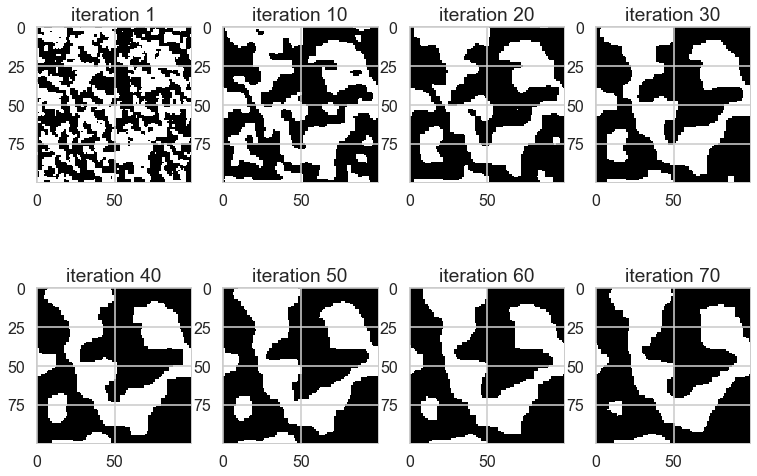

In [259]:
indices = [1,10,20,30,40,50,60,70]
i = 4
for j in range(len(indices)):
    plt.subplot(2,4,j+1)
    index = indices[j]
    plt.imshow(fields[index])
    plt.title('iteration '+str(index))

###  plot energy and magnetization as a function of iteration

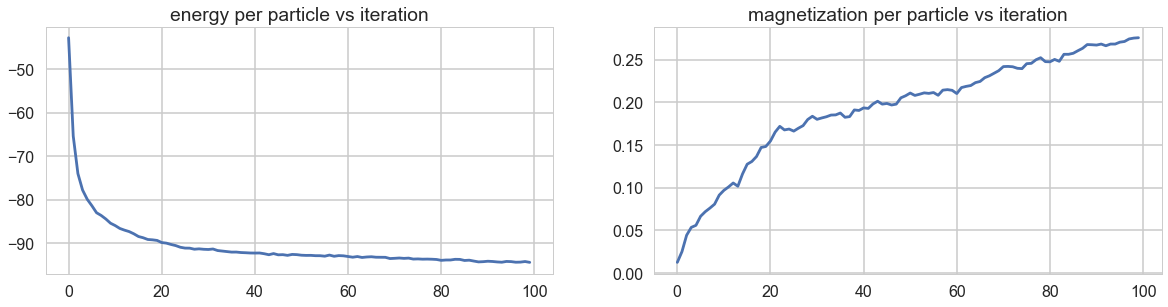

In [302]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(np.array(energies)/(100*2))
plt.title('energy per particle vs iteration')
plt.subplot(222)
plt.plot(magnetizations)
plt.title('magnetization per particle vs iteration')

## Calculate energy and magnetization for different betas 

In [179]:
fig = plt.figure()
betas = np.logspace(-5,5,5)
energies_temps = []
fields_temps = []
magnetizations_temps= []
burnin = 1200
n_iterations = 2000

for i, b in enumerate(betas):
    field = 2*np.random.binomial(1, 0.5, size=(100, 100)) -1
    start=time.time()
    fields, energies, magnetizations = ising_gibbs(field, n_iterations, b=b, plot_map=False, h=0)
    
    e_i = np.mean(energies[burnin:])
    m_i = np.mean(magnetizations[burnin:])
    
    #save 
    fields_temps.append(fields)
    energies_temps.append(energies)
    magnetizations_temps.append(magnetizations)
    
    print ('beta: ', b, '  energy: ', e_i, '  magnetization: ', m_i)
    end =time.time()
    print(end-start)

beta:  1e-05   energy:  -0.36   magnetization:  0.0002625
311.53682684898376
beta:  0.00316227766017   energy:  -60.51125   magnetization:  -2.825e-05
306.64090514183044
beta:  1.0   energy:  -19459.58125   magnetization:  -0.16777675
307.83451294898987
beta:  316.227766017   energy:  -19931.74625   magnetization:  0.9637715
325.58671522140503
beta:  100000.0   energy:  -20000.0   magnetization:  1.0
317.441251039505


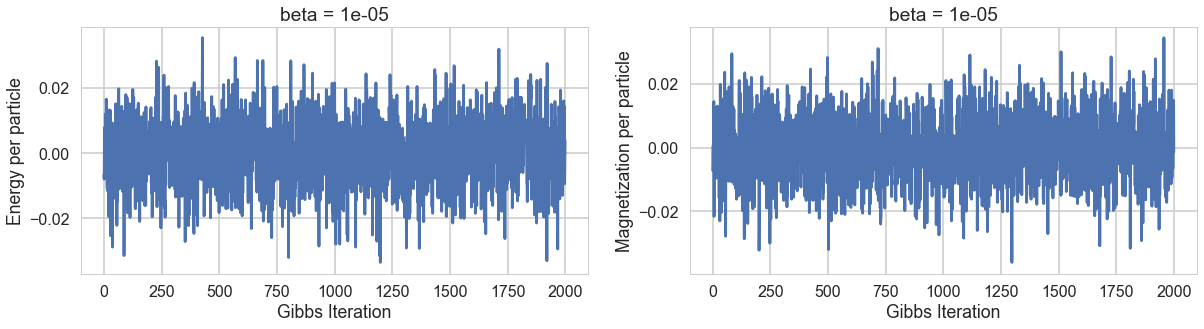

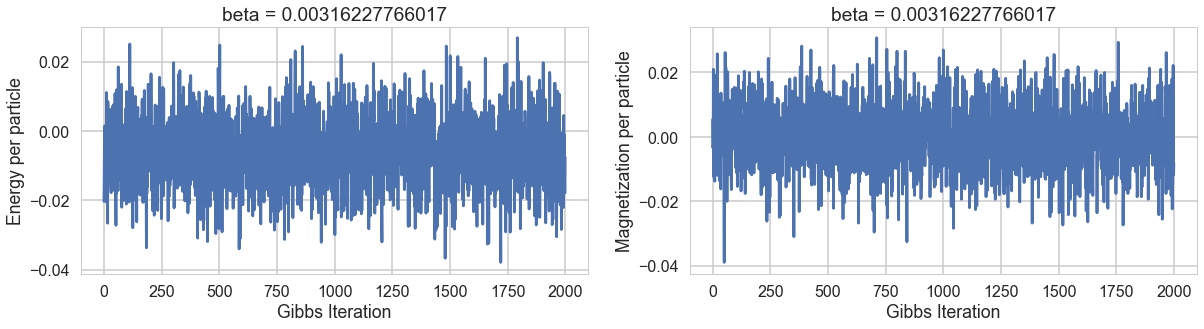

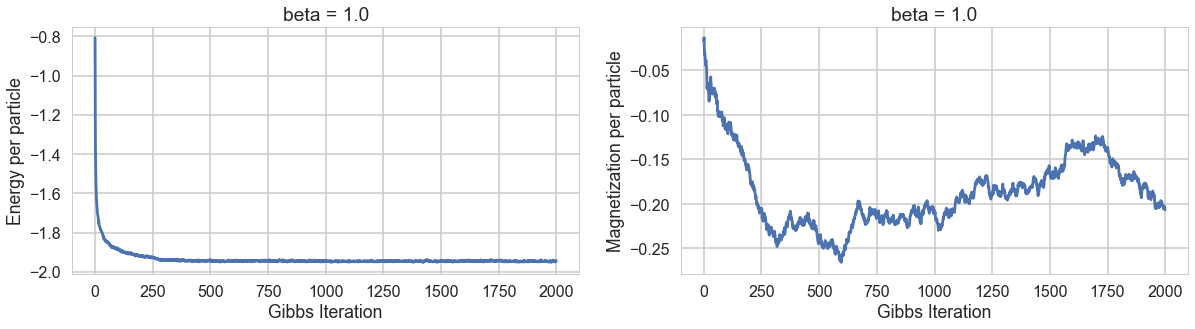

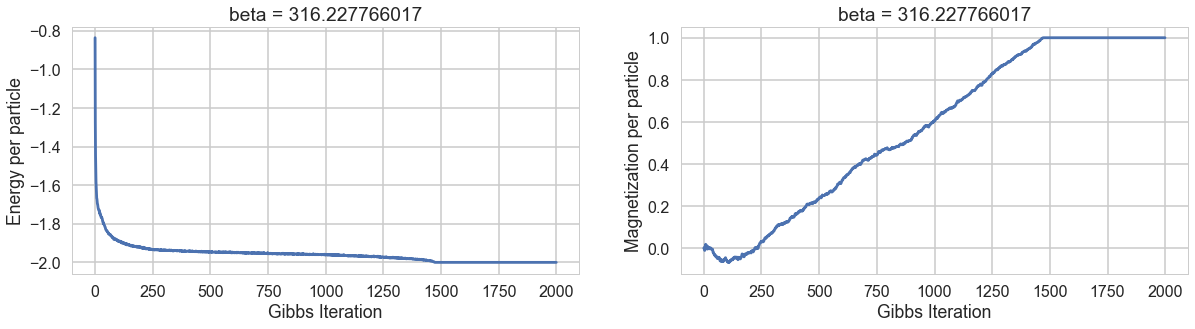

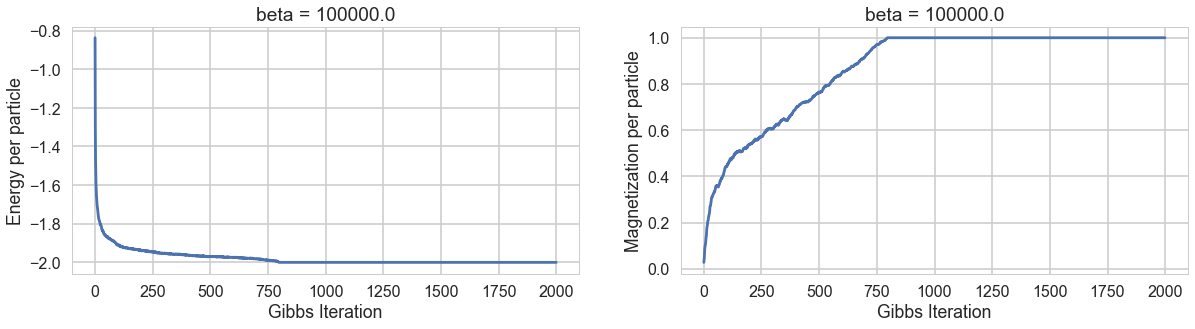

In [304]:
for i in range(len(betas)):
    plt.figure(figsize=(20,10))
    plt.subplot(221)
    plt.plot(np.array(energies_temps[i])/(100*100))
    plt.xlabel('Gibbs Iteration')
    plt.ylabel('Energy per particle')
    plt.title('beta = ' + str(betas[i]))
    plt.subplot(222)
    plt.plot(magnetizations_temps[i])
    plt.xlabel('Gibbs Iteration')
    plt.ylabel('Magnetization per particle')
    plt.title('beta = ' + str(betas[i]))

Based on the plots of energy and magnetization as a function of iteration, several observations can be made:
- for small values of beta (high temp) the magnetization and energy randomly oscillate around 0
- for beta = 1, the energy converges quickly but the magnetization oscillates and resembles an unconverged markov chain
- for large values of beta (small temp) the energy converges quickly (after approx 500-750 iterations) and the magnetization value goes from 0 to +1.0 
- the maximum number of iterations required for convergence of magnetization is 1500 (this can be set as the burnin period)

In [306]:
burnin = 1500
magnetizations_final = [np.mean(m[burnin:]) for m in magnetizations_temps]
energies_final = [np.mean(e[burnin:])/(100*100) for e in energies_temps]

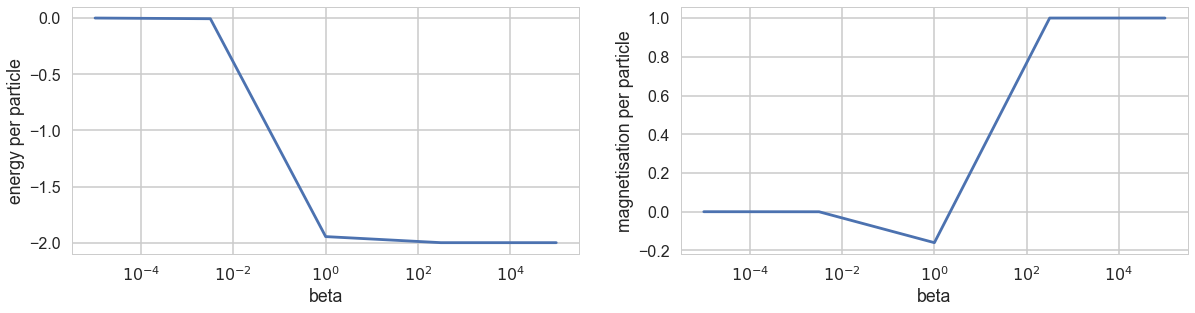

In [307]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.ylabel('energy per particle')
plt.xlabel('beta')
plt.semilogx(betas, energies_final)
plt.subplot(222)
plt.ylabel('magnetisation per particle')
plt.xlabel('beta')
plt.semilogx(betas, magnetizations_final)

Considering the plot of energy vs $\beta$ a phase transition appears to occur around $\beta = 0.1$. For $\beta$ values greater than 1, the energy stays constant, and similarly for $\beta$ values less than 0.01, the energy is also constant. 

The magnetization plot shows a similar behavior - for small values of $\beta$ the magnetization is 0, but for $\beta$ values greater than 1, the magnetization increases to 1 and remains constant at 1. 

### Part B

Now add an external field of magnitude $h > 0$, which can be interpreted as an energy term added to each spin, and repeat the experiment in Part (A).

In this case:

$$
E = -\sum_{ij} \frac{1}{2} s_{ij}  \left[ s_{\rm{up}(ij)} + s_{\rm{down}(ij)} + s_{\rm{left}(ij)} + s_{\rm{right}(ij)} \right]  - \sum_{ij} h_{ij} s_{ij}
$$

where $h_{ij}$ is the magnitude of the external field in the $(i,j)$ position of the lattice, and $s_{ij}$ the spin in that location in the lattice. For the sake of simplicity, we will assume that $h$ is constant over the entire lattice. 

Note that the above implies that adjacent spins with the same sign result in lower energy than adjacent spins with opposite signs. Also, if the spin direction and the direction of the external magnetic field are aligned, the energy is reduced.

Use a low temperature, $\beta=1$, and plot the magnetization as a function of the Gibbs itearation for the following values of the external field: $h = -1.0,-0.1,-0.05,0.05,0.1,1.0$. Discuss the effect of adding this external field on the magnetization properties.

In [60]:
field = 2*np.random.binomial(1, 0.5, size=(100, 100)) -1
fields, energies, magnetizations = ising_gibbs(field, 100, b=1, plot_map=False, h=1)

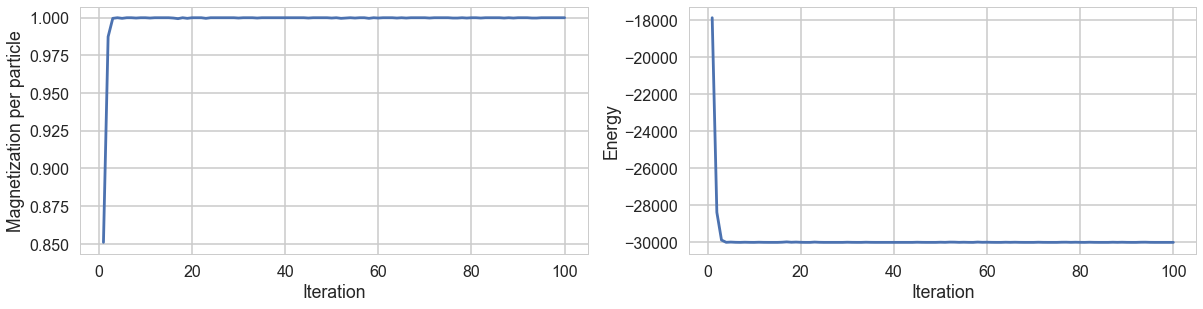

In [61]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(range(1,101), magnetizations)
plt.ylabel('Magnetization per particle')
plt.xlabel('Iteration')
plt.subplot(222)
plt.plot(range(1,101), energies)
plt.ylabel('Energy')
plt.xlabel('Iteration')

In [65]:
h_range = [-1.0, -0.1, -0.05, 0.05, 0.1, 1.0]
fig = plt.figure()
energies_h = []
fields_h = []
magnetizations_h = []
n_iterations = 500

for i, h in enumerate(h_range):
    print('h ', h)
    field = 2*np.random.binomial(1, 0.5, size=(100, 100)) -1
    start = time.time()
    fields, energies, magnetizations = ising_gibbs(field, n_iterations, b=1, plot_map=False, h=h)
    
    #save 
    fields_h.append(fields)
    energies_h.append(energies)
    magnetizations_h.append(magnetizations)

    end =time.time()
    print(end-start)

h  -1.0
116.7853569984436
h  -0.1
117.54856085777283
h  -0.05
115.10387825965881
h  0.05
200.1099932193756
h  0.1
482.11778593063354
h  1.0
129.5738730430603


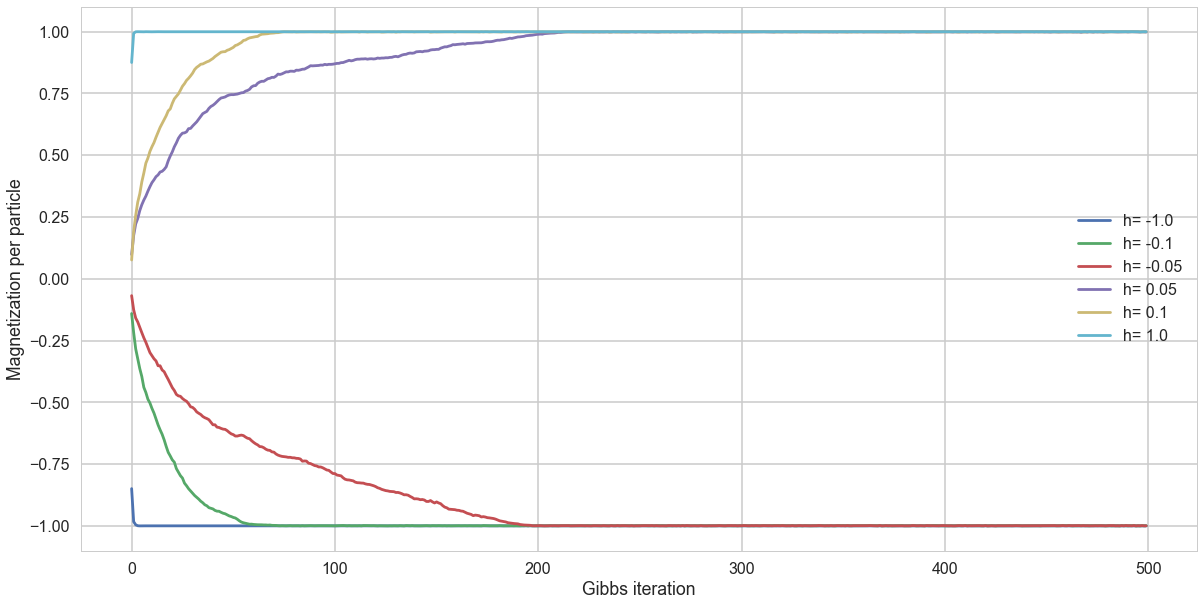

In [66]:
plt.figure(figsize=(20,10))
for i, m in enumerate(magnetizations_h):
    plt.plot(m, label='h= '+ str(h_range[i]))
plt.xlabel('Gibbs iteration')
plt.ylabel('Magnetization per particle')
plt.legend(loc='best')

From the plot of magnetization vs Gibbs field for different values of the external magnetic field, it can be seen that the effect of h is to polarise the field one way or the other i.e. magnetization per particle is either -1.0 or +1.0. For larger values of the external field the magnetic field reaches +1 or -1 in fewer Gibbs iterations (polarization occurs faster for stronger external fields). 

## Problem 2. Image de-noising

Suppose we observe a "noisy" image $Y \in \{-1,1\}^L$ (a lattice) based on a "noise-free" image $Z \in \{-1,1\}^L$. We will denote the random variable representing the value at the $i$-pixel in the two images by $Y_i$ and $Z_i$, respectively. A plausible choice for modelling the noise in $Y$ is by using independent bit-flips:


$$
P(Y_i=y_i\vert Z_i=z_i) = P(Z_i=z_i\vert Y_i=y_i) = \left\{
        \begin{array}{ll}
            q & \quad y_i = z_i \\
            1-q & \quad y_i \neq z_i
        \end{array}
    \right.
$$

where $q >0$. Simply put, if the $i$-th pixel $Z_i$ in the noise-free image is a -1, then the $i$-th pixel in $Y$ will be wrong (i.e. $Y_i=1$) with probability $1 - q$.

We want to recover $Z$, the original noise-free image. The problem is hard unless we make an assumption about $Z$. We will assume that the image is "clumpy", i.e., that neighboring pixels are correlated. We can translate this assumption directly into the prior probability of $Z$:

$$
\text{Prior on Lattice }Z = P(Z) \propto \exp \left( \sum_{i,j}z_iz_j\right)
$$

Looks familiar? Yes, that is an Ising model with no external field! Now, applying Bayes' rule, and setting $$h=\log\left(\frac{q}{1-q}\right) = \mathrm{logit}(q),$$ 
we can write the posterior probability as:

$$
\log P(Z\vert Y) \propto \exp \left( \sum_{i,j}z_iz_j + \sum_i h\cdot z_i\cdot y_i \right)
$$

This is exactly an Ising model with a varying external field $h\cdot y_i$. We only need to set $\beta=2$ and halve $h$.

### Part A

Using a Gibbs sampler, de-noise the image contained in the file "noisy_image.pickle" and plot your result. How many Gibbs iterations do you need in order to obtain a clean image?

In [283]:
with open('noisy_image.pickle', 'rb') as f:
    noisy_image = pickle.load(f)

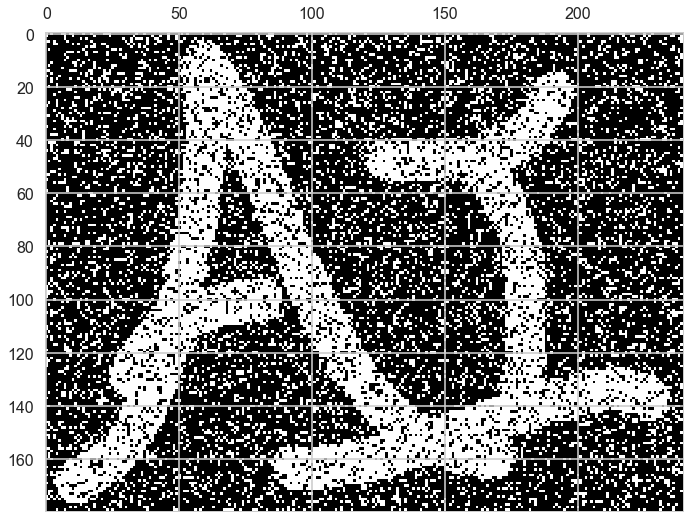

In [284]:
plt.spy(noisy_image+1)

In [285]:
def ising_gibbs_2(field, N, b, plot_map,h):
#     fig = plt.figure()
    samples = [field.copy()]
    energies = []
    magnetizations = []
    x_size, y_size = np.shape(field)
    lattice_coords = DataFrame([(x,y) for x in range(x_size) for y in range(y_size)])
    for _ in range(1,N+1):
        E = 0
        for x, y in lattice_coords.values:
            s, e = update_spin_2(field, x, y, b, h=h)
            field[x, y] = s
            E += e*(-0.5)*field[x,y] - (h*field[x,y])
        energies.append(E)
        samples.append(field.copy())
        magnetizations.append(np.sum(field)/(x_size*y_size))
        
        if plot_map:
            ax = fig.add_subplot(2,5,_)
            ax.set_title("Iteration "+str(_))
            plt.spy(field+1)
            
    return samples, energies, magnetizations

In [286]:
N = 20
image_field = noisy_image.copy()
fields_image, energies_image, magnetizations_image = ising_gibbs_2(image_field, N, b=2, plot_map=False,h=0.5)

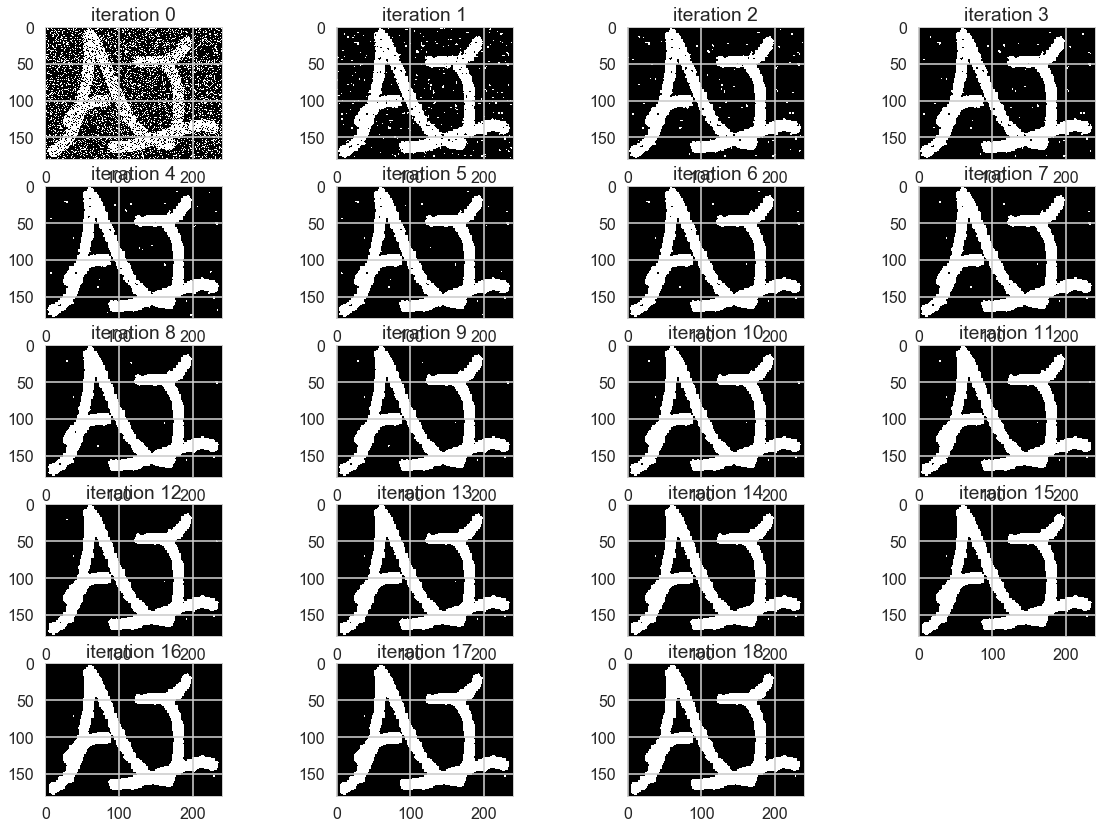

In [290]:
plt.figure(figsize=(20,20))
indexes = np.arange(0,N, 2)
x = int(len(indexes)/3)
for i in range(1, 20):
    plt.subplot(7,4, i)
    plt.imshow(fields_image[i-1])
    plt.title('iteration '+ str(i-1))

After just 20 iterations, the clarity of the image has improved considerably. 